In [400]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
!pip install shap
import shap
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(19)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 6.0 MB/s eta 0:00:00


In [187]:
# Training loss
@torch.no_grad()
def get_stats(datain):
  X, y = datain[:]
  preds = model(X)
  loss = loss_fn(preds, y)
  classifications = torch.round(nn.Sigmoid()(preds))
  true_pos = 0
  true_neg = 0
  false_pos = 0
  false_neg = 0
  for i in range(len(classifications)):
    if classifications[i] == 1:
      if y[i] == 1:
        true_pos += 1
      else: false_pos += 1
    else:
      if y[i] == 1:
        false_neg += 1
      else: true_neg += 1
  print(f"**Loss: {loss.item():.4f}**")
  print()
  print("Confusion Matrix: ")
  print()
  print("|    | Tp | Tn |")
  print("|---|---|---|")
  print("| Pp |", true_pos, "|", false_pos )
  print("| Pn |", false_neg, "|", true_neg )
  accuracy = (true_pos + true_neg)/(true_pos + true_neg + false_pos + false_neg)
  precision = (true_pos)/(true_pos + false_pos)
  recall = (true_pos)/(true_pos + false_neg)
  f1 = 2*precision*recall/(precision + recall)
  print()
  print("|Stat|Value|")
  print("|---|---|")
  print(f"|Accuracy | {accuracy:.4f}")
  print(f"|Precision | {precision:.4f}")
  print(f"|Recall | {recall:.4f}")
  print(f"|F1 | {f1:.4f}")

In [362]:
!unzip titanic.zip
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [363]:
df['class1'] = df['Pclass'] == 1
df['class2'] = df['Pclass'] == 2
df['class3'] = df['Pclass'] == 3
df['embarkedS'] = df['Embarked'] == 'S'
df['embarkedC'] = df['Embarked'] == 'C'
df['embarkedQ'] = df['Embarked'] == 'Q'
df['female'] = df['Sex'] == 'female'
test_df['class1'] = test_df['Pclass'] == 1
test_df['class2'] = test_df['Pclass'] == 2
test_df['class3'] = test_df['Pclass'] == 3
test_df['embarkedS'] = test_df['Embarked'] == 'S'
test_df['embarkedC'] = test_df['Embarked'] == 'C'
test_df['embarkedQ'] = test_df['Embarked'] == 'Q'
test_df['female'] = test_df['Sex'] == 'female'

In [365]:
training_df = df[['class1', 'class2', 'class3', 'embarkedS', 'embarkedC', 'embarkedQ', 'female', 'Fare', 'Age', 'SibSp', 'Parch']].copy()
for c in training_df.columns:
  training_df[c] = training_df[c].astype('float32')
training_df['Age'] = training_df['Age'].fillna(training_df['Age'].mean())
labels = df['Survived'].astype('float32')
features = training_df.shape[1]

ids = test_df['PassengerId']
test_df = test_df[['class1', 'class2', 'class3', 'embarkedS', 'embarkedC', 'embarkedQ', 'female', 'Fare', 'Age', 'SibSp', 'Parch']].copy()
for c in test_df.columns:
  test_df[c] = test_df[c].astype('float32')
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].mean())

In [366]:
X = torch.tensor(training_df.values)
y = torch.unsqueeze(torch.tensor(labels.values), 1)
XTest = torch.tensor(test_df.values)

In [367]:
split_data = random_split(TensorDataset(X, y), [0.9, 0.1])
training_data = split_data[0]
val_data = split_data[1]

In [368]:
hidden1 = 50
out = 1

In [369]:
model = nn.Sequential(
    nn.Linear(features, hidden1), nn.ReLU(),
    # nn.Linear(hidden1, hidden2), nn.ReLU(),
    nn.Linear(hidden1, out)
)

In [370]:
epochs = 100
lr = 0.1
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)

In [371]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
losses = []
iters = 0
for _ in range(epochs):
  for Xb, Yb in train_dataloader:
    preds = model(Xb)
    loss = loss_fn(preds, Yb)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())
    iters += 1

In [373]:
print("# Training Data")
print()
get_stats(training_data)
print("# Validation Data")
print()
get_stats(val_data)

# Training Data

**Loss: 0.4068**

Confusion Matrix: 

|    | Tp | Tn |
|---|---|---|
| Pp | 251 | 103
| Pn | 56 | 392

|Stat|Value|
|---|---|
|Accuracy | 0.8017
|Precision | 0.7090
|Recall | 0.8176
|F1 | 0.7595
# Validation Data

**Loss: 0.4510**

Confusion Matrix: 

|    | Tp | Tn |
|---|---|---|
| Pp | 32 | 14
| Pn | 3 | 40

|Stat|Value|
|---|---|
|Accuracy | 0.8090
|Precision | 0.6957
|Recall | 0.9143
|F1 | 0.7901


**First attempt:**

# Training data:

**Loss: 0.3570**

Confusion Matrix:

|    | Tp | Tn |
|----|----|----|
| Pp | 255 | 64 |
| Pn | 56 | 427 |

|Stat|Value|
|---|---|
|Accuracy | 0.8504
|Precision | 0.7994
|Recall | 0.8199|
|F1 | 0.8095|

# Validation data

**Loss: 0.6677**

Confusion Matrix:

|    | Tp | Tn |
|----|----|----|
| Pp | 23 | 18
| Pn | 8 | 40

|Stat|Value|
|---|---|
|Accuracy | 0.7079
|Precision | 0.5610
|Recall | 0.7419
|F1 | 0.6389


**Second Attempt**

I simplified the model, reduced it to two layers to reduce the overfitting. Need to reduce overfitting more

# Training Data

**Loss: 0.3468**

Confusion Matrix:

|    | Tp | Tn |
|---|---|---|
| Pp | 234 | 50
| Pn | 75 | 443

|Stat|Value|
|---|---|
|Accuracy | 0.8441
|Precision | 0.8239
|Recall | 0.7573
|F1 | 0.7892

# Validation Data

**Loss: 0.4784**

Confusion Matrix:

|    | Tp | Tn |
|---|---|---|
| Pp | 20 | 7
| Pn | 13 | 49

|Stat|Value|
|---|---|
|Accuracy | 0.7753
|Precision | 0.7407
|Recall | 0.6061
|F1 | 0.6667

**Third Attempt**

Simplified further, only one layer now, with hidden dim 50 instead of 100
# Training Data
**Loss: 0.3985**

Confusion Matrix:

|    | Tp | Tn |
|---|---|---|
| Pp | 247 | 87
| Pn | 62 | 406

|Stat|Value|
|---|---|
|Accuracy | 0.8142
|Precision | 0.7395
|Recall | 0.7994
|F1 | 0.7683

# Validation Data
**Loss: 0.4394**

Confusion Matrix:

|    | Tp | Tn |
|---|---|---|
| Pp | 24 | 9
| Pn | 9 | 47

|Stat|Value|
|---|---|
|Accuracy | 0.7978
|Precision | 0.7273
|Recall | 0.7273
|F1 | 0.7273

In [411]:
explainer = shap.DeepExplainer(model, training_data[:][0])
shap_values = explainer.shap_values(training_data[:][0])

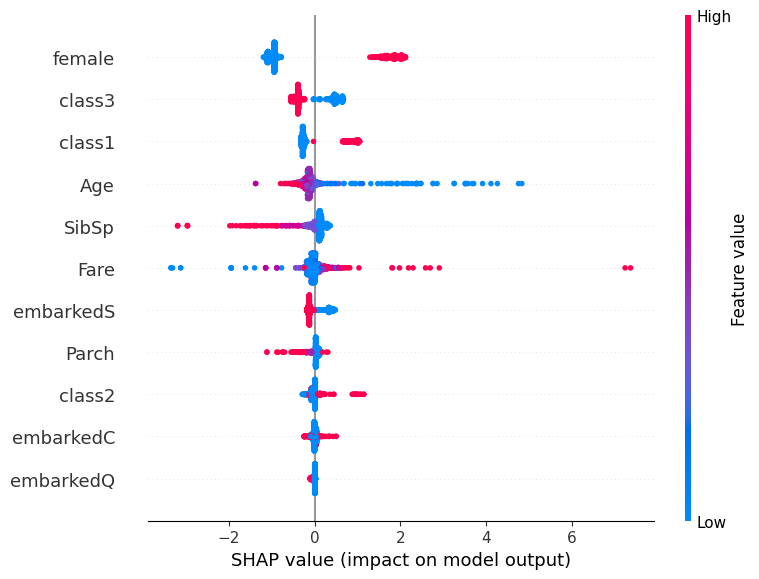

In [412]:
shap.summary_plot(shap_values, training_data[:][0], training_df.columns)

In [393]:
classifications = torch.round(nn.Sigmoid()(model(XTest))).to(int)

In [394]:
classifications_series = pd.Series(classifications.squeeze().detach().numpy())

In [395]:
classifications_series.name = 'Survived'

In [396]:
ids.name = 'PassengerId'

In [397]:
result_df = pd.concat([ids, classifications_series], axis=1)

In [398]:
result_df.to_csv('results.csv', index=False)